In [49]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use ('fivethirtyeight')
import plotly.express as px

In [50]:
df = pd.read_csv('BTC-USD.csv')
df = df.set_index('Date')

In [51]:
df.shape

(367, 6)

In [52]:
df=df.dropna()

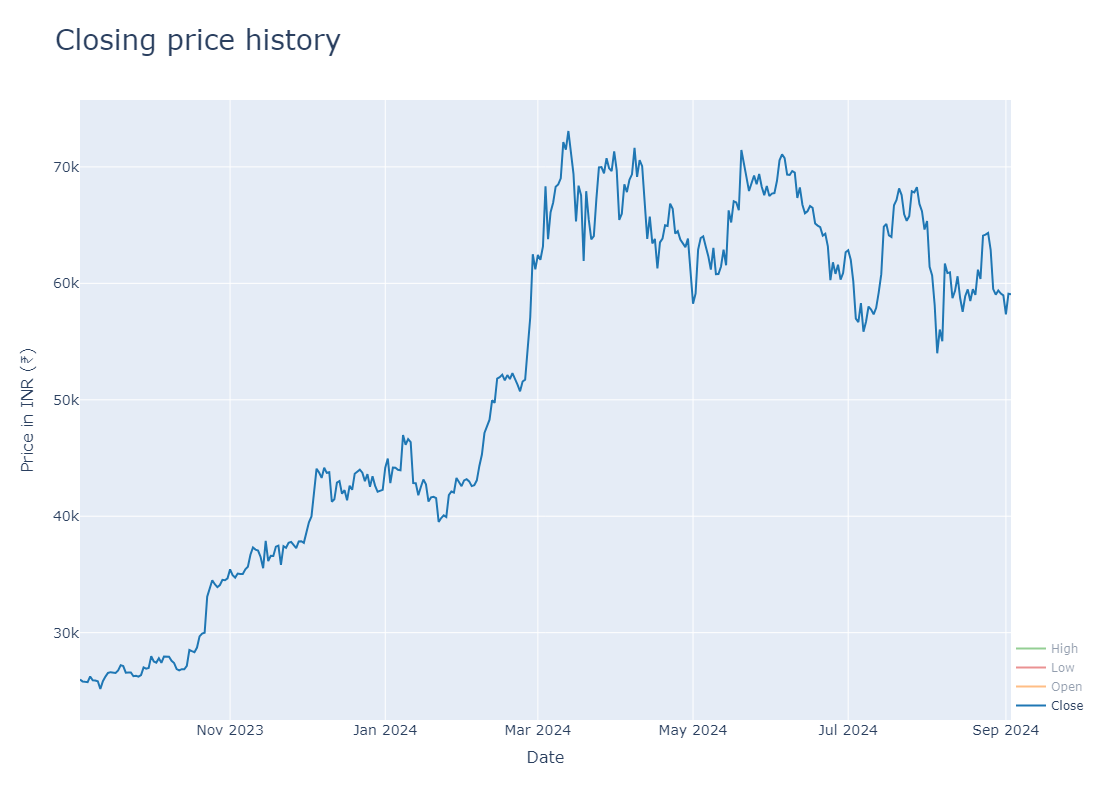

In [53]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df.index, y = df.High,mode='lines',name='High',marker_color = '#2CA02C',visible = "legendonly"))
fig.add_trace(go.Scatter(x = df.index, y = df.Low,mode='lines',name='Low',marker_color = '#D62728',visible = "legendonly"))
fig.add_trace(go.Scatter(x = df.index, y = df.Open,mode='lines',name='Open',marker_color = '#FF7F0E',visible = "legendonly"))
fig.add_trace(go.Scatter(x = df.index, y = df.Close,mode='lines',name='Close',marker_color = '#1F77B4'))

fig.update_layout(title='Closing price history',titlefont_size = 28,
                  xaxis = dict(title='Date',titlefont_size=16,tickfont_size=14),height = 800,
                  yaxis=dict(title='Price in INR (₹)',titlefont_size=16,tickfont_size=14),
                  legend=dict(y=0,x=1.0,bgcolor='rgba(255, 255, 255, 0)',bordercolor='rgba(255, 255, 255, 0)'))
fig.show()

In [54]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

In [55]:
training_data_len

294

In [56]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01683844],
       [0.01355906],
       [0.01288225],
       [0.01232412],
       [0.02248585],
       [0.01550473],
       [0.01529655],
       [0.01397246],
       [0.        ],
       [0.01399578],
       [0.02223813],
       [0.02873529],
       [0.03017557],
       [0.02933227],
       [0.02862081],
       [0.03321367],
       [0.0427468 ],
       [0.04109597],
       [0.02931873],
       [0.0295678 ],
       [0.02956409],
       [0.0228329 ],
       [0.02370213],
       [0.02200703],
       [0.02483392],
       [0.0387909 ],
       [0.03649907],
       [0.03767174],
       [0.05886991],
       [0.04941755],
       [0.04731394],
       [0.05502282],
       [0.04702041],
       [0.05809462],
       [0.05855877],
       [0.05785448],
       [0.0505213 ],
       [0.04650096],
       [0.03569774],
       [0.0332662 ],
       [0.03546934],
       [0.0354554 ],
       [0.04167285],
       [0.07004911],
       [0.06788473],
       [0.06606076],
       [0.07422975],
       [0.094

In [57]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [58]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(234, 60, 1)

In [59]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error') #dog=input output=cat
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

C:\Users\YAMINI\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0260


In [64]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range (60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rsme = np.sqrt(np.mean(predictions - y_test) ** 2)
rsme

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


3131.47966595548

In [68]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\YAMINI\AppData\Local\Temp\ipykernel_11056\2657761684.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



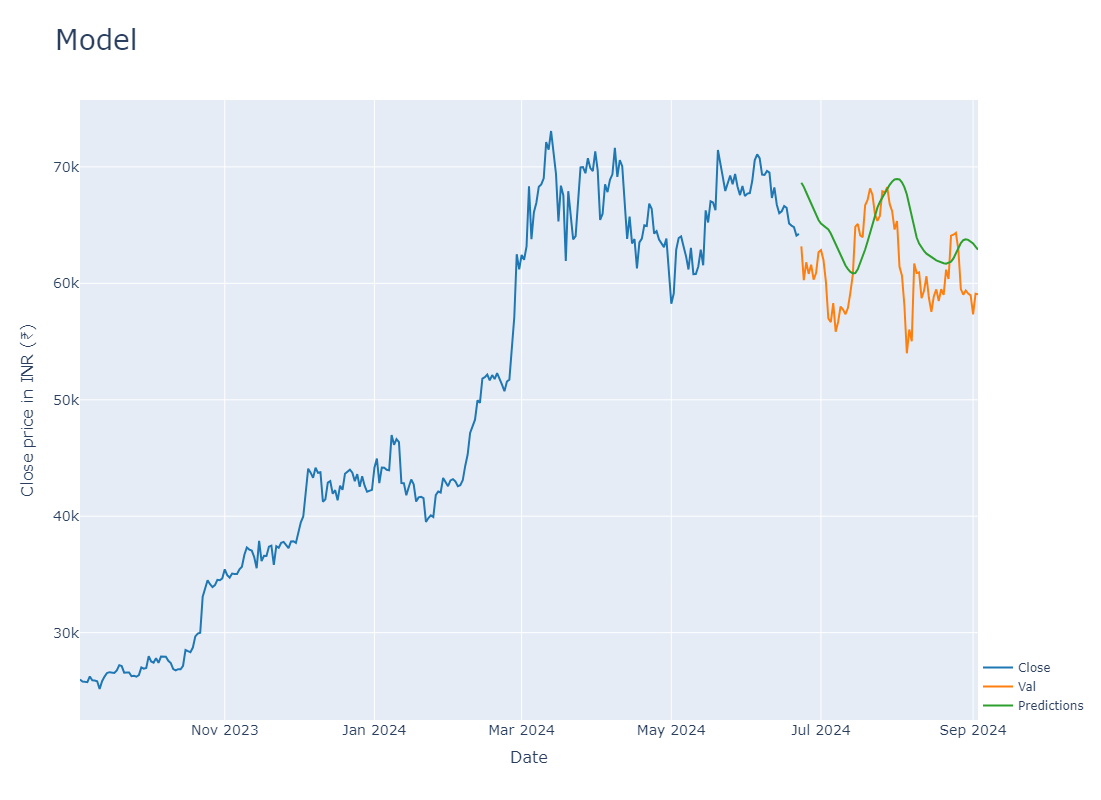

In [70]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = train.index, y = train.Close,mode='lines',name='Close',marker_color = '#1F77B4'))
fig.add_trace(go.Scatter(x = valid.index, y = valid.Close,mode='lines',name='Val',marker_color = '#FF7F0E'))
fig.add_trace(go.Scatter(x = valid.index, y = valid.Predictions,mode='lines',name='Predictions',marker_color = '#2CA02C'))

fig.update_layout(title='Model',titlefont_size = 28,hovermode = 'x',
                  xaxis = dict(title='Date',titlefont_size=16,tickfont_size=14),height = 800,
                  yaxis=dict(title='Close price in INR (₹)',titlefont_size=16,tickfont_size=14),
                  legend=dict(y=0,x=1.0,bgcolor='rgba(255, 255, 255, 0)',bordercolor='rgba(255, 255, 255, 0)'))
fig.show()